In [1]:
import os
import cv2
import numpy as np
from skimage.feature import hog
from skimage import color, filters
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from glob import glob
import random

In [2]:
# Data directories
train_data_dir = "data/train_images/"
val_data_dir = "data/val_images/"

In [3]:
# Helper function to load images and labels
def load_images(data_dir):
    images = []
    labels = []
    class_names = sorted(os.listdir(data_dir))
    for label, class_name in enumerate(class_names):
        class_dir = os.path.join(data_dir, class_name)
        for img_path in glob(os.path.join(class_dir, "*.jpg")):
            img = cv2.imread(img_path)
            if img is not None:
                img = cv2.resize(img, (128, 128))
                images.append(img)
                labels.append(label)
    return np.array(images), np.array(labels), class_names

In [4]:
# Load data
print("Loading Train Images, Labels")
train_images, train_labels, class_names = load_images(train_data_dir)
print("Loadig for Train Complete")
print("Loading Validation Images, Labels")
val_images, val_labels, _ = load_images(val_data_dir)
print("Loading for Val Complete")

Loading Train Images, Labels
Loadig for Train Complete
Loading Validation Images, Labels
Loading for Val Complete


In [5]:
# Defining HOG Paramters for Feature Extraction
hog_params = {
    'orientations': 6,
    'pixels_per_cell': (8, 8),
    'cells_per_block': (2, 2),
    'block_norm': 'L2-Hys',
    'visualize': False
}

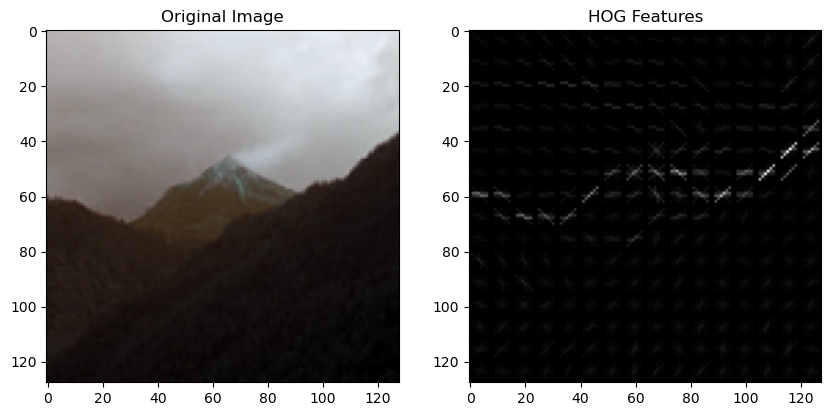

In [6]:
# Test HOG on a random image
random_idx = random.randint(0, len(train_images) - 1)
test_img = train_images[random_idx]
test_img_gray = color.rgb2gray(test_img)
hog_features, hog_image = hog(
    test_img_gray,
    orientations=hog_params['orientations'],
    pixels_per_cell=hog_params['pixels_per_cell'],
    cells_per_block=hog_params['cells_per_block'],
    visualize=True
)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(test_img)
plt.title("Original Image")
plt.subplot(1, 2, 2)
plt.imshow(hog_image, cmap='gray')
plt.title("HOG Features")
plt.show()

In [7]:
# Extract HOG features for all training and validation images
def extract_hog_features(images):
    features = []
    for img in images:
        img_gray = color.rgb2gray(img)
        hog_feat = hog(
            img_gray,
            orientations=hog_params['orientations'],
            pixels_per_cell=hog_params['pixels_per_cell'],
            cells_per_block=hog_params['cells_per_block'],
            block_norm=hog_params['block_norm'],
            visualize=False
        )
        features.append(hog_feat)
    return np.array(features)

In [8]:
print("Extracting for Train Images")
hog_train_features = extract_hog_features(train_images)
print("Extracting for Train Complete")
print("Extracting for Val Images")
hog_val_features = extract_hog_features(val_images)
print("Extracting for Val Complete")

Extracting for Train Images
Extracting for Train Complete
Extracting for Val Images
Extracting for Val Complete


In [9]:
# Defining color histogram parameters
hist_params = {
    'bins': 32,
    'range': (0, 256)
}

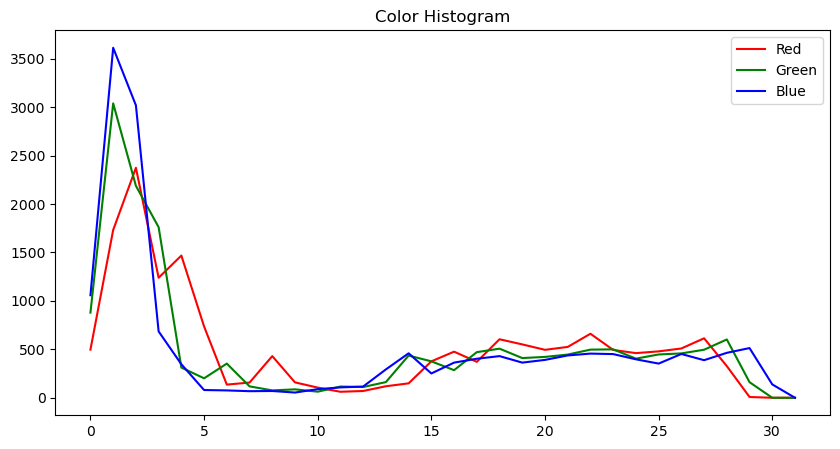

In [10]:
# Test Color Histogram on a random image
test_img_rgb = train_images[random_idx]
hist_r = cv2.calcHist([test_img_rgb], [0], None, [hist_params['bins']], hist_params['range'])
hist_g = cv2.calcHist([test_img_rgb], [1], None, [hist_params['bins']], hist_params['range'])
hist_b = cv2.calcHist([test_img_rgb], [2], None, [hist_params['bins']], hist_params['range'])

plt.figure(figsize=(10, 5))
plt.plot(hist_r, color='r', label='Red')
plt.plot(hist_g, color='g', label='Green')
plt.plot(hist_b, color='b', label='Blue')
plt.title("Color Histogram")
plt.legend()
plt.show()

In [11]:
# Extract Color Histogram features
def extract_color_histogram(images):
    features = []
    for img in images:
        hist_r = cv2.calcHist([img], [0], None, [hist_params['bins']], hist_params['range'])
        hist_g = cv2.calcHist([img], [1], None, [hist_params['bins']], hist_params['range'])
        hist_b = cv2.calcHist([img], [2], None, [hist_params['bins']], hist_params['range'])
        hist = np.concatenate([hist_r, hist_g, hist_b]).flatten()
        features.append(hist)
    return np.array(features)

In [12]:
print("Extracting for Train Images")
color_train_features = extract_color_histogram(train_images)
print("Extracting for Train Images Complete")
print("Extracting for Val Images")
color_val_features = extract_color_histogram(val_images)
print("Extracting for Val Images Complete")

Extracting for Train Images
Extracting for Train Images Complete
Extracting for Val Images
Extracting for Val Images Complete


In [13]:
scaler_hog = StandardScaler()
scaler_color = StandardScaler()

In [14]:
hog_train_scaled = scaler_hog.fit_transform(hog_train_features)
hog_val_scaled = scaler_hog.transform(hog_val_features)

In [15]:
color_train_scaled = scaler_color.fit_transform(color_train_features)
color_val_scaled = scaler_color.transform(color_val_features)

In [16]:
train_features = np.hstack((hog_train_scaled, color_train_scaled))
val_features = np.hstack((hog_val_scaled, color_val_scaled))

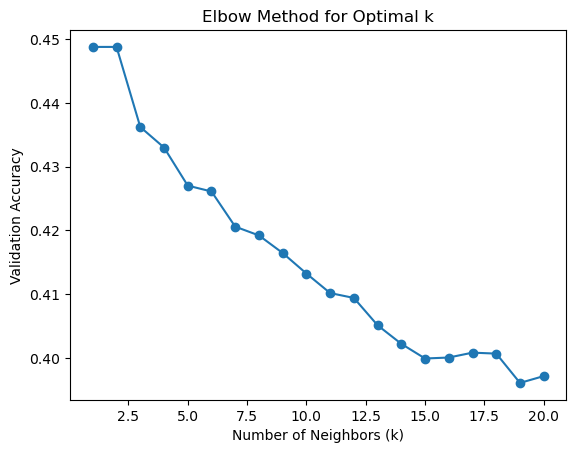

In [17]:
import matplotlib.pyplot as plt

k_values = list(range(1, 21))
accuracies = []

for k in k_values:
    model = KNeighborsClassifier(n_neighbors=k, metric='manhattan', weights='distance')
    model.fit(train_features, train_labels)
    predictions = model.predict(val_features)
    accuracies.append(accuracy_score(val_labels, predictions))

plt.plot(k_values, accuracies, marker='o')
plt.xlabel("Number of Neighbors (k)")
plt.ylabel("Validation Accuracy")
plt.title("Elbow Method for Optimal k")
plt.show()

In [29]:
# Train and evaluate KNN with HOG features
def train_evaluate_knn(train_features, train_labels, val_features, val_labels):

    # Define and train KNN model
    knn_model = KNeighborsClassifier(n_neighbors=2, metric='manhattan')
    knn_model.fit(train_features, train_labels)
    predictions = knn_model.predict(val_features)

    # Compute evaluation metrics
    metrics = {
        'accuracy': accuracy_score(val_labels, predictions),
        'precision': precision_score(val_labels, predictions, average='weighted'),
        'recall': recall_score(val_labels, predictions, average='weighted'),
        'f1': f1_score(val_labels, predictions, average='weighted')
    }
    return metrics

In [59]:
knn_metrics = train_evaluate_knn(train_features, train_labels, val_features, val_labels)
print(knn_metrics)

{'accuracy': 0.45861434702636417, 'precision': 0.602001965037335, 'recall': 0.45861434702636417, 'f1': 0.4074310897140653}


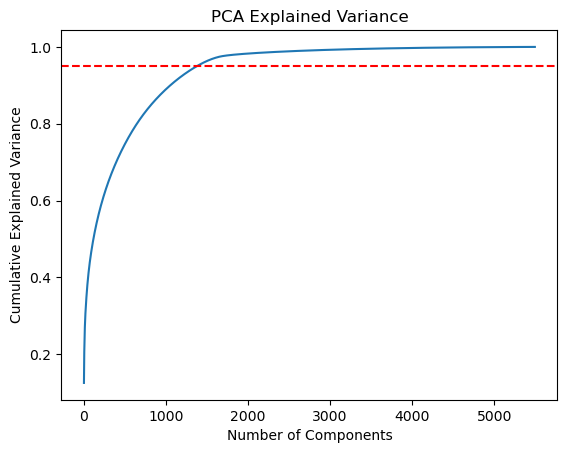

In [25]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA

# Fit PCA without setting n_components to analyze variance
pca = PCA()
pca.fit(train_features)

# Plot variance explained by each component
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("PCA Explained Variance")
plt.axhline(y=0.95, color='r', linestyle='--')  # 95% variance threshold
plt.show()

In [79]:
pca = PCA(n_components=16)
train_features_pca = pca.fit_transform(train_features)
val_features_pca = pca.transform(val_features)

In [80]:
knn_model = train_evaluate_knn(train_features_pca, train_labels, val_features_pca, val_labels)
print(knn_model)

{'accuracy': 0.632280809319436, 'precision': 0.6567060399506102, 'recall': 0.632280809319436, 'f1': 0.6270834867450966}


In [81]:
import joblib

# Save the trained KNN model
joblib.dump(knn_model, "knn_model.pkl")

# # Load the saved model
# knn_model_loaded = joblib.load("knn_model.pkl")

['knn_model.pkl']